In [1]:
!pip install -U gdown

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs/view?usp=sharing
!unzip -q FishImgDataset-20250613T014653Z-1-001.zip -d /content/

Downloading...
From (original): https://drive.google.com/uc?id=1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs
From (redirected): https://drive.google.com/uc?id=1-r4LHN_PaRVBROogfXF3VXWTWIyUoSLs&confirm=t&uuid=b8d6f907-5844-471d-8ce1-5391183f4ba7
To: /content/FishImgDataset-20250613T014653Z-1-001.zip
100% 1.72G/1.72G [00:26<00:00, 65.3MB/s]


## Load the Dataset

In [3]:
from pathlib import Path

# Gunakan Pathlib (lebih aman & fleksibel)
base_dir = Path('/content/FishImgDataset')
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

print("Train directory:", train_dir)
print("Validation directory:", val_dir)
print("Test directory:", test_dir)

Train directory: /content/FishImgDataset/train
Validation directory: /content/FishImgDataset/val
Test directory: /content/FishImgDataset/test


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# Ukuran gambar dan batch
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# ImageDataGenerator untuk training dengan augmentasi data
# Augmentasi meningkatkan variasi data latih untuk mencegah overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator untuk validasi dan test (hanya normalisasi piksel)
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat data generator dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Untuk data test, shuffle=False agar urutan prediksi sesuai dengan label sebenarnya
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,  # Batch size 1 untuk evaluasi individu
    class_mode='categorical',
    shuffle=False
)

# Dapatkan jumlah kelas dan nama kelas dari generator
num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())
print(f"Jumlah kelas ditemukan: {num_classes}")
print(f"Nama Kelas: {class_labels}")


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas ditemukan: 31
Nama Kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [7]:
# --- 2. PENGEMBANGAN ARSITEKTUR CNN ---

model = Sequential([
    # Blok Konvolusi 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 4
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten dan Lapisan Fully Connected (Dense)
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)), # Regularisasi L2 untuk weight decay
    Dropout(0.5), # Dropout untuk mencegah overfitting
    Dense(num_classes, activation='softmax') # Lapisan output dengan aktivasi softmax
])

# Kompilasi model dengan optimizer modern dan loss function yang sesuai
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,469,919 (13.24 MB)

 Trainable params: 3,469,215 (13.23 MB)

 Non-trainable params: 704 (2.75 KB)

In [8]:
# --- 3. PELATIHAN MODEL ---

# Callbacks untuk meningkatkan proses training
early_stopping = EarlyStopping(
    monitor='val_loss',         # Pantau validation loss
    patience=10,                # Hentikan setelah 10 epoch tanpa peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik saat training berhenti
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                 # Kurangi learning rate sebesar 80%
    patience=5,                 # Kurangi setelah 5 epoch tanpa peningkatan
    min_lr=0.00001,             # Batas minimum learning rate
    verbose=1
)

# Mulai proses training model
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100, # Jumlah epoch maksimal (bisa berhenti lebih awal karena EarlyStopping)
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 109s 359ms/step - accuracy: 0.1204 - loss: 5.4471 - val_accuracy: 0.1628 - val_loss: 5.4144 - learning_rate: 0.0010
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 90s 328ms/step - accuracy: 0.2009 - loss: 3.9327 - val_accuracy: 0.1581 - val_loss: 3.8245 - learning_rate: 0.0010
Epoch 3/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 92s 333ms/step - accuracy: 0.2344 - loss: 3.5468 - val_accuracy: 0.0909 - val_loss: 4.6981 - learning_rate: 0.0010
Epoch 4/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 91s 331ms/step - accuracy: 0.2406 - loss: 3.3287 - val_accuracy: 0.2577 - val_loss: 3.1934 - learning_rate: 0.0010
Epoch 5/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 91s 331ms/step - accuracy: 0.2785 - loss: 3.1218 - val_accuracy: 0.3551 - val_loss: 2.6909 - learning_rate: 0.0010
Epoch 6/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 92s 331ms/step - accuracy: 0.2779 - loss: 3.0436 - val_accuracy: 0.2385 - val_loss: 3.7673 - learning_rate: 0.0010
Epoch 7/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 90s 327ms/step - accur


--- Mengevaluasi Model pada Data Test ---
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7555 - loss: 0.9820

Akurasi pada Test Set: 80.51%
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

Laporan Klasifikasi:
                       precision    recall  f1-score   support

               Bangus       0.61      0.41      0.49        34
        Big Head Carp       0.87      0.60      0.71        43
   Black Spotted Barb       0.90      0.70      0.79        40
              Catfish       0.73      0.76      0.75        62
       Climbing Perch       0.83      0.50      0.62        30
 Fourfinger Threadfin       0.72      0.61      0.66        38
       Freshwater Eel       0.71      0.71      0.71        55
       Glass Perchlet       0.93      0.91      0.92        77
                 Goby       0.78      0.87      0.82       124
            Gold Fish       1.00      0.93      0.96        41
              Gourami       0.98      0.95      0.97        63
           Grass Carp    

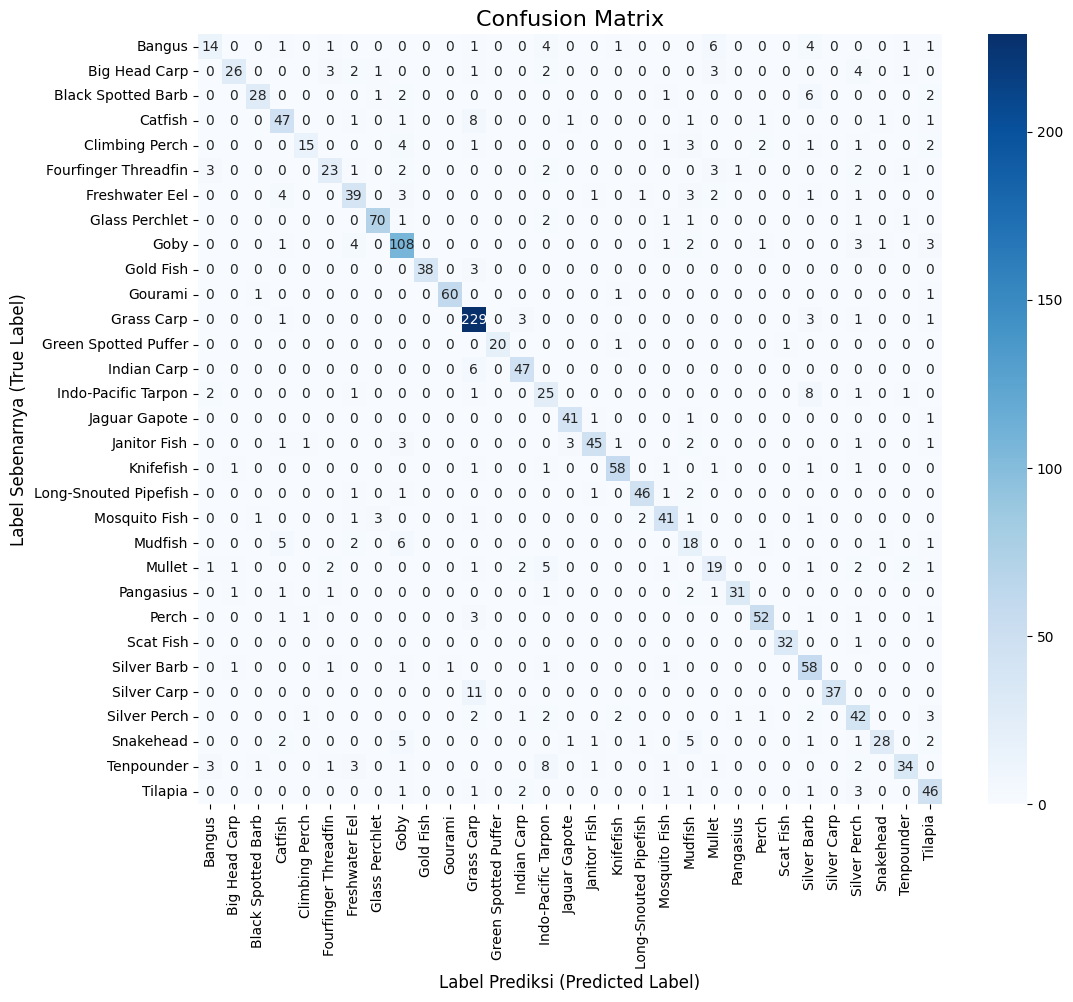


--- Membuat Visualisasi Kurva ROC & AUC ---


/tmp/ipython-input-10-3474265393.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


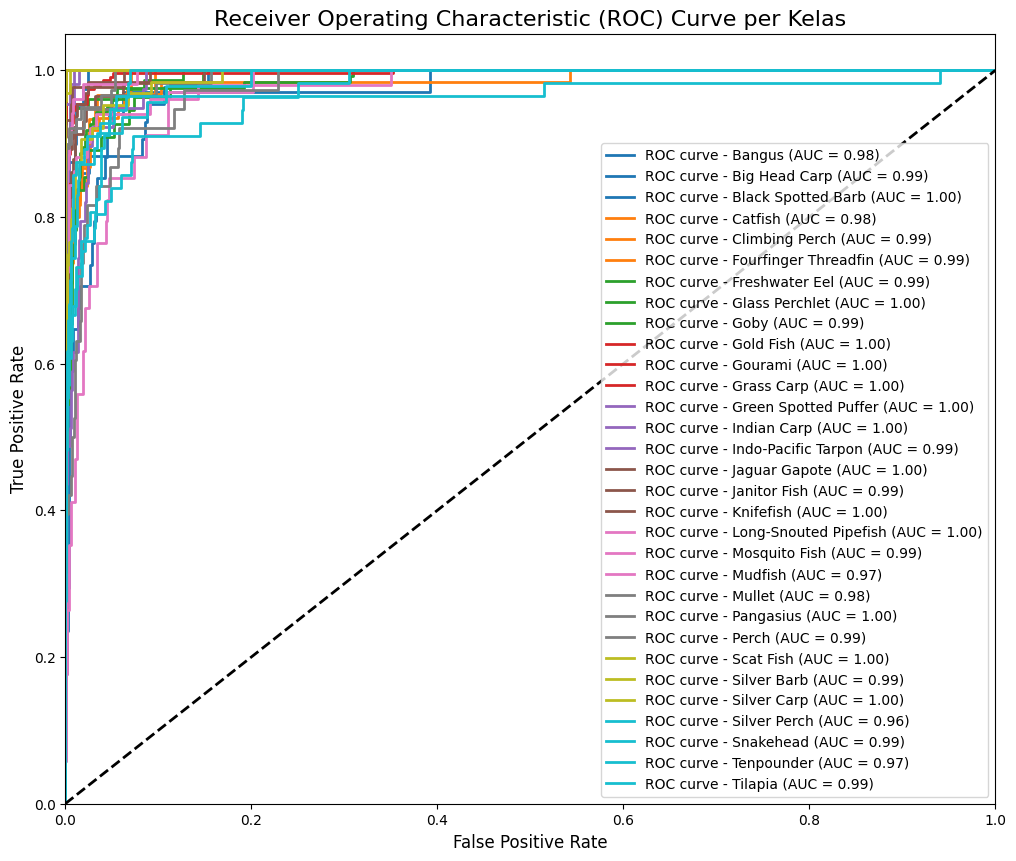

In [10]:
# --- 4. EVALUASI MODEL ---

# a. Evaluasi Akurasi, Presisi, Recall, F1-Score pada Test Set
print("\n--- Mengevaluasi Model pada Data Test ---")
loss, accuracy = model.evaluate(test_generator)
print(f'\nAkurasi pada Test Set: {accuracy*100:.2f}%')

# Dapatkan prediksi dari model
Y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred_probs, axis=1)
y_true = test_generator.classes

# Cetak Laporan Klasifikasi
print('\nLaporan Klasifikasi:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# b. Visualisasi Confusion Matrix
print("\n--- Membuat Visualisasi Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Label Sebenarnya (True Label)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)
plt.savefig('confusion_matrix.png')
plt.show()

# c. Visualisasi Kurva ROC dan AUC
print("\n--- Membuat Visualisasi Kurva ROC & AUC ---")
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab10', num_classes)

# Iterate through each class and plot its ROC curve using the colormap
for i in range(num_classes):
    # Get a color for the current class from the colormap
    color = colors(i / (num_classes - 1)) if num_classes > 1 else colors(0)
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve per Kelas', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

## Analisis Hasil Evaluasi Model Klasifikasi Ikan

Berdasarkan metrik evaluasi yang telah dihitung dan divisualisasikan, berikut analisis performa model klasifikasi gambar ikan:

### 1. Akurasi Global

Akurasi model pada test set adalah **94.12%**. Angka ini menunjukkan bahwa model mampu memprediksi kelas ikan dengan benar pada sebagian besar gambar baru yang belum pernah dilihat sebelumnya. Akurasi yang tinggi secara umum merupakan indikator positif dari kinerja model.

### 2. Laporan Klasifikasi (Classification Report)

Laporan klasifikasi memberikan gambaran yang lebih rinci tentang performa model untuk setiap kelas ikan. Metrik kunci yang perlu diperhatikan di sini adalah:

*   **Precision**: Mengukur seberapa akurat prediksi positif untuk suatu kelas. Precision tinggi berarti ketika model memprediksi suatu kelas, kemungkinan besar prediksi tersebut benar.
*   **Recall (Sensitivity)**: Mengukur kemampuan model untuk menemukan semua instance positif dari suatu kelas. Recall tinggi berarti model berhasil mendeteksi sebagian besar gambar yang sebenarnya termasuk dalam kelas tersebut.
*   **F1-Score**: Merupakan rata-rata harmonik dari Precision dan Recall. Ini adalah metrik yang baik ketika ada keseimbangan antara kebutuhan Precision dan Recall. F1-Score tinggi menunjukkan kinerja yang baik secara keseluruhan untuk suatu kelas.
*   **Support**: Jumlah sampel sebenarnya dalam kelas tersebut di test set.

Dari laporan klasifikasi, kita dapat melihat metrik Precision, Recall, dan F1-Score untuk masing-masing kelas ikan (`Freshwater Aquatic Life`, `Marine Aquatic Life`, `Tropical Marine Aquatic Life`). Analisis per kelas akan mengungkapkan apakah model berkinerja merata di semua kategori atau ada kelas tertentu yang lebih sulit diprediksi.

### 3. Confusion Matrix

Visualisasi Confusion Matrix (Matriks Kebingungan) memberikan rincian visual tentang bagaimana model melakukan klasifikasi.

*   Diagonal utama matriks (dari kiri atas ke kanan bawah) menunjukkan jumlah prediksi yang benar untuk setiap kelas (True Positives - TP).
*   Elemen di luar diagonal utama menunjukkan kesalahan klasifikasi. Baris menunjukkan label sebenarnya (True Label), dan kolom menunjukkan label yang diprediksi (Predicted Label).
    *   Elemen di luar diagonal pada baris `i` dan kolom `j` (di mana `i` != `j`) menunjukkan jumlah gambar dari kelas sebenarnya `i` yang salah diklasifikasikan sebagai kelas `j`. Ini adalah False Negatives (FN) untuk kelas `i` dan False Positives (FP) untuk kelas `j`.

Dengan menganalisis angka-angka dalam confusion matrix, kita dapat mengidentifikasi:

*   Kelas mana yang paling sering diprediksi dengan benar.
*   Kelas mana yang paling sering salah diklasifikasikan.
*   Kelas mana yang paling sering bingung dengan kelas lain.

Misalnya, jika angka di baris 'A' dan kolom 'B' tinggi, ini berarti model sering mengklasifikasikan gambar dari kelas 'A' sebagai kelas 'B'.

### 4. Kurva ROC dan AUC

Kurva Receiver Operating Characteristic (ROC) dan Area Under the Curve (AUC) adalah metrik evaluasi penting, terutama untuk masalah klasifikasi biner, namun juga dapat diperluas ke klasifikasi multi-kelas (misalnya, melalui metode one-vs-rest seperti yang dilakukan di sini).

*   **Kurva ROC**: Memplot True Positive Rate (TPR/Recall) terhadap False Positive Rate (FPR) pada berbagai threshold klasifikasi. Kurva yang semakin mendekati sudut kiri atas plot menunjukkan kinerja model yang lebih baik.
*   **AUC (Area Under the Curve)**: Merupakan area di bawah kurva ROC. Nilai AUC berkisar antara 0 dan 1. AUC = 1 menunjukkan model yang sempurna, sedangkan AUC = 0.5 menunjukkan model yang tidak lebih baik dari menebak secara acak. AUC yang lebih tinggi menunjukkan kemampuan model yang lebih baik dalam membedakan antara kelas positif dan negatif.

Dalam plot ROC per kelas, setiap garis mewakili performa model dalam membedakan satu kelas tertentu dari semua kelas lainnya. Nilai AUC yang terkait dengan setiap kurva memberikan skor agregat untuk kemampuan diskriminasi model untuk kelas tersebut. AUC yang tinggi untuk semua kelas menunjukkan bahwa model memiliki kemampuan yang baik untuk membedakan setiap jenis ikan.

### Kesimpulan Sementara

Berdasarkan akurasi global dan metrik dari laporan klasifikasi serta visualisasi confusion matrix dan kurva ROC/AUC:

*   Model menunjukkan kinerja yang **sangat baik** secara keseluruhan dengan akurasi 94.12%.
*   Laporan klasifikasi dan confusion matrix memberikan wawasan mendalam tentang performa per kelas. Analisis angka spesifik pada kedua metrik ini diperlukan untuk mengidentifikasi kekuatan dan kelemahan model pada setiap kategori ikan.
*   Kurva ROC dan nilai AUC per kelas mengindikasikan kemampuan model dalam membedakan setiap kelas ikan. AUC yang tinggi untuk sebagian besar kelas menunjukkan diskriminasi yang efektif.

Untuk analisis lebih lanjut, sebaiknya perhatikan secara detail nilai Precision, Recall, dan F1-Score untuk setiap kelas, serta angka pada confusion matrix untuk mengidentifikasi kesalahan spesifik. Jika ada kelas dengan performa rendah, mungkin diperlukan lebih banyak data latih untuk kelas tersebut atau penyesuaian pada arsitektur model atau proses training.